In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Import and Discovery

## Data Loader

In this section, an MNistDataLoader() class is defined with some basic functions to read the binary data from the dataset and load them as lists of data instances.

In [3]:
import numpy as np # linear algebra
import struct
from array import array
from os.path import join
import kagglehub


# Download latest version
dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", dataset_path)


# MNIST Data Loader Class

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    # Function to read the labels and load
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)      

c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\mnguyen6\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


## Data Visualization

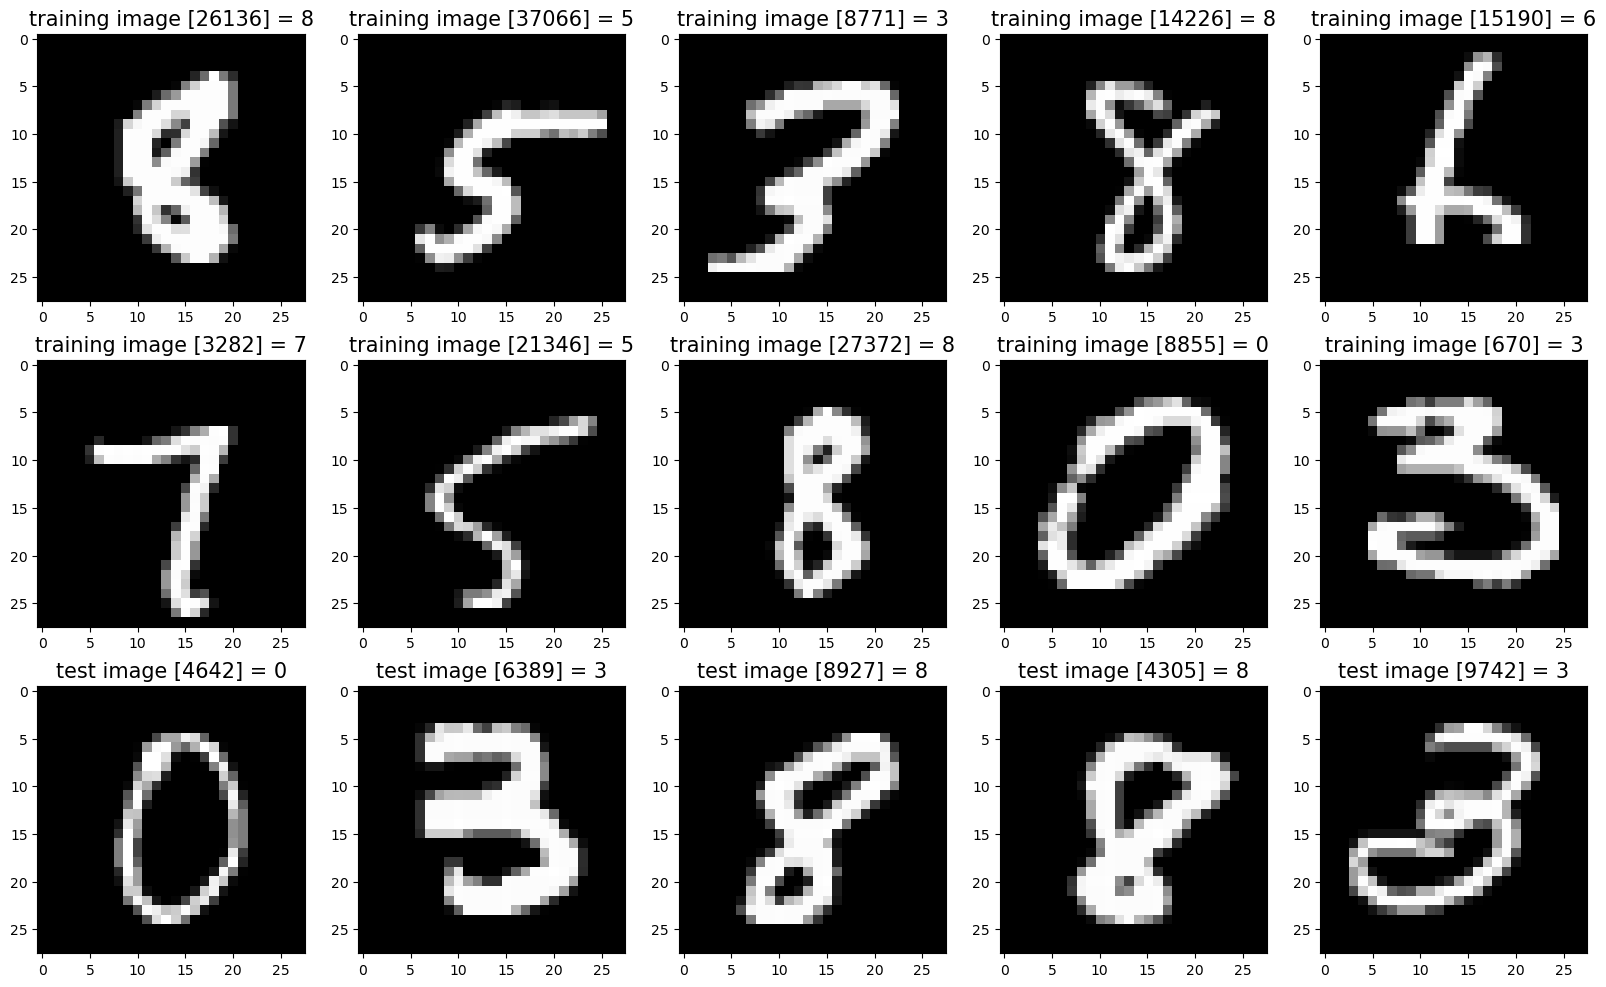

In [4]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets
base_path = 'data'
training_images_filepath = join(base_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(base_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(base_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(base_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols)
    plt.figure(figsize=(cols*4,rows*4))
    
    for index, x in enumerate(zip(images, title_texts)):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index+1)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        


# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_trainval, y_trainval), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_trainval[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_trainval[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [5]:
x_trainval_dim = x_trainval.shape
y_trainval_dim = y_trainval.shape

x_test_dim = x_test.shape
y_test_dim = y_test.shape

print(f"There are {x_trainval_dim[0]} samples in the training dataset, each of size {x_trainval_dim[1],x_trainval_dim[2]} \n"
      f"There are {x_test_dim[0]} samples in the testing dataset ")

print(f"The training label set has dimension of {y_trainval_dim}")

There are 60000 samples in the training dataset, each of size (28, 28) 
There are 10000 samples in the testing dataset 
The training label set has dimension of (60000,)


In [6]:
NUM_CLASS = len(np.unique(y_trainval))

## Train-Validation Data Split

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=12)

x_train_dim = np.shape(x_train)
y_train_dim = np.shape(y_train)

x_val_dim = np.shape(x_val)
y_val_dim = np.shape(y_val)

print("After the train-validation data split")

print(f"There are {x_train_dim[0]} samples in the training dataset, each of size {x_train_dim[1:]}. \n"
      f"There are {x_val_dim[0]} samples in the validation dataset.\n"
      f"There are {x_test_dim[0]} samples in the testing dataset.")

print(f"The training label set has dimension of {y_train_dim}")

# The input shape to the NN is the number of pixels in an MNIST image (28x28=784 input)
INPUT_SHAPE = x_train_dim[1:]

After the train-validation data split
There are 48000 samples in the training dataset, each of size (28, 28). 
There are 12000 samples in the validation dataset.
There are 10000 samples in the testing dataset.
The training label set has dimension of (48000,)


In [11]:
INPUT_SHAPE

(28, 28)

## Data Generator

I found that when training or evaluating a model on a GPU with limited RAM (such as 8GB RAM cards like the T1000 or RTX4060), the code often fails since TensorFlow tries to load the full arrays into the GPU memory (even when loading in batches). This code block is an attempt to solve this problem by using a generator to generate data from the training sets to the model in batches. These generators are used directly in model training and testing

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(x_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(x_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(x_test,y_test,BATCH_SIZE)

# Deep Fully-Connected ANN Implementation

## ANN Model Construction Function

In [9]:
import tensorflow as tf                                 # General machine learning functionalities                    
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

def build_ann_model(layer_widths, 
                    input_shape, 
                    activation='relu', 
                    loss='sparse_categorical_crossentropy', 
                    metrics='accuracy', 
                    learning_rate=0.001):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    # Add additional hidden layers based on layer_widths
    model.add(layers.Flatten(input_shape=input_shape))
    for i,width in enumerate(layer_widths):
        model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer with width = number of class and softmax activation
    model.add(layers.Dense(NUM_CLASS, activation='softmax', name = "Output_layer"))

    # Compile the model with the provided or default learning rate, loss functions, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=loss, 
                  metrics=metrics)
    
    return model

In [17]:
INPUT_SHAPE+(1,)

(28, 28, 1)

## Testing with one ANN model construction

In [20]:
LAYER_WIDTHS = [64,32]
LAYER_DEPTH = len(LAYER_WIDTHS)
LEARNING_RATE = 0.001
EPOCH = 5
ACTIVATION = 'relu'
LOSS = 'sparse_categorical_crossentropy'
METRICS = 'accuracy'

tf.keras.backend.clear_session()
model = build_ann_model(layer_widths=LAYER_WIDTHS,
                        input_shape=INPUT_SHAPE+(1,),
                        activation=ACTIVATION,
                        loss=LOSS,
                        metrics=METRICS,
                        learning_rate=LEARNING_RATE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 Output_layer (Dense)        (None, 10)                3

### Model Experimentation Training

In [21]:
from time import time

train_start = time()
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)
train_end = time()

TRAIN_TIME = train_end - train_start

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3517 - accuracy: 0.8997 - val_loss: 0.1745 - val_accuracy: 0.9472
Epoch 2/5
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1604 - accuracy: 0.9513 - val_loss: 0.1448 - val_accuracy: 0.9574
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1171 - accuracy: 0.9637 - val_loss: 0.1187 - val_accuracy: 0.9650
Epoch 4/5
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0935 - accuracy: 0.9705 - val_loss: 0.1131 - val_accuracy: 0.9658
Epoch 5/5
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0779 - accuracy: 0.9761 - val_loss: 0.1030 - val_accuracy: 0.9703


### Model directory
This section create the directory that corresponds to the time of the current run and store the training parameters, training performance, evaluation, and testing plots

In [ ]:
import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run

# Generate a timestamped directory for the training run
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR,f"ann_model_results/{timestamp}_{LAYER_DEPTH}_{LEARNING_RATE}_{EPOCH}")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
BASE_DIR

'd:\\Minh Nguyen\\programming-project\\mnist'

In [ ]:
from contextlib import redirect_stdout

# Save the model in H5DF format
MODEL_PATH = os.path.join(OUTPUT_DIR,"model.h5")
model.save(MODEL_PATH)
print(f"Model saved as {MODEL_PATH}")

# Save the model structure
model_path = os.path.join(OUTPUT_DIR, "model_summary.json")
with open(model_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

# Save the training parameters
training_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCH,
    "structure": str(LAYER_WIDTHS),
    "loss": LOSS,
    "metrics": METRICS,
    "activation": 'relu'
}

# Store the final training results
training_results = {}
for i in history.history.keys():
    training_results[i] = history.history[i][-1]
training_results['train_time'] = TRAIN_TIME
# Save the training parameters and training results in the directory
params_path = os.path.join(OUTPUT_DIR, "params_results.json")
with open(params_path, "w") as f:
    json.dump({"parameters": training_params, "results": training_results}, f, indent=4)
print(f"Training parameters and results saved at {params_path}")

Model saved as d:\Minh Nguyen\programming-project\mnist\ann_model_results/241203_220851_2_0.001_5\model.h5
Training parameters and results saved at d:\Minh Nguyen\programming-project\mnist\ann_model_results/241203_220851_2_0.001_5\params_results.json


### Helper function to plot the training performance

Here I defined a helper function that plots the training history and stores in the directory defined above

In [61]:
def plot_performance(history, training_params=None, save_dir=None):
    # Determine whether history is keras history or a dictionary to appropriately extract the history data
    if isinstance(history, keras.callbacks.History):
        history_data = history.history        # Extract the history dictionary
    else:
        history_data = history                # Assume it's already a dictionary

    metric_list = list(history_data.keys())     # Extract the list of history keys
    half_length = len(metric_list) // 2         # The index where the validation metrics start

    metric2txt_dict = {'accuracy': 'Accuracy',
                       'loss': 'Sparse Caregorical Crossentropy Loss'}

    fig = plt.figure(figsize=(half_length * 5,5))

    for index, metric in enumerate(metric_list[:half_length]):
        metric_train = metric
        metric_val = metric_list[index+half_length]

        ax = fig.add_subplot(1,half_length,index+1)
        ylim_acc = [0, max(max(history_data[metric_train]),max(history_data[metric_val]))]
        ax.plot(history_data[metric_train], label = metric_train)
        ax.plot(history_data[metric_val], label = metric_val)
        ax.set_ylim(ylim_acc)
        # plt.ylabel(metric_train)
        ax.set_xlabel('Epoch')
        ax.legend(loc='best')
        ax.set_title(f'{metric2txt_dict[metric_train]}')

        ax.grid(which='major', color='black', linestyle='--', linewidth=0.5)
        ax.minorticks_on()  # Turn on the minor ticks
        ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
        
    if training_params:
        fig.suptitle(f"{training_params['structure']} model, lr={training_params['learning_rate']}, "
                    f"{training_params['epochs']} epochs, {training_params['activation']} activation")

    plt.tight_layout()
    
    # Save the plots if a directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        plot_path = os.path.join(save_dir, "performance_plot.png")
        plt.savefig(plot_path)
        print(f"Performance plot saved at {plot_path}")

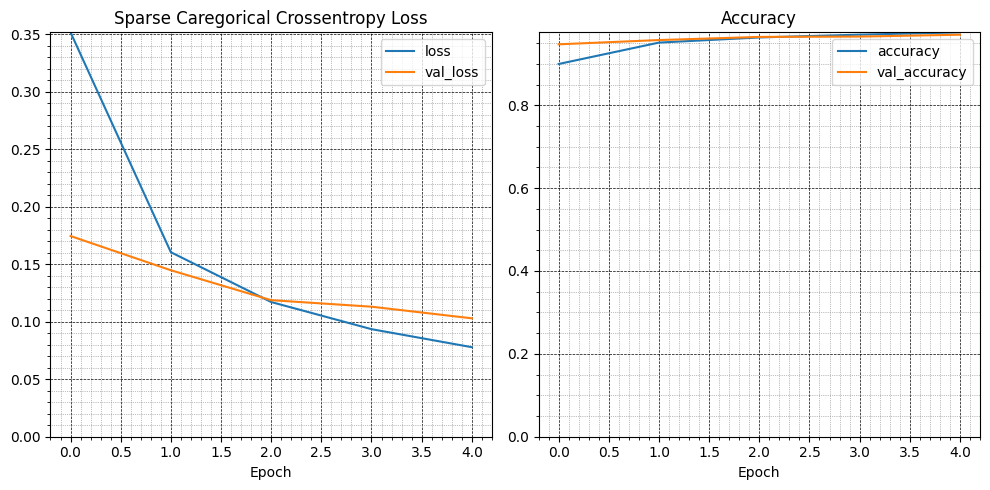

In [62]:
plot_performance(history)

## Grid Search Model Training

### Grid Setup

In [ ]:
LAYER_WIDTHS = [[64,32],[32,16],[64,32,16],[32,16,8]]               # Architectures to be experimented with
LAYER_DEPTH = [len(i) for i in LAYER_WIDTHS]                        # Depth of each architecture
LEARNING_RATE = [0.001, 0.0005, 0.0001]
EPOCH = [10,25,50]
ACTIVATION = ['relu','sigmoid']
LOSS = 'sparse_categorical_crossentropy'
METRICS = 'accuracy'

### Experiment Setup

In this experiment, the algorithm will train the model with each hyperparameter combinations in a grid search fashion. In each iteraction, the algorithm will
- Create a new directory corresponding to the training time and the current hyperparameter configuration
- Build the model using the "build_ann_model() function defined above
- Save the training parameters in a "training_params" dictionary
- Save the model summary/structure into a "model_summary.json" file
- Train the model and save the training time and final training result in a "training_results" dictionary
- Store the training parameters and final training results into a "params_results.json" file
- Save the model for future inference and testing
- Plot the model training history and save the figure in the directory

In [10]:
for layer_width in LAYER_WIDTHS:
    for lr in LEARNING_RATE:
        for epoch in EPOCH:
            for activation in ACTIVATION:

                # Create the directory for this 
                timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
                BASE_DIR = os.getcwd()
                OUTPUT_DIR = os.path.join(BASE_DIR,f"ann_model_results/{timestamp}_{str(layer_width)}_{lr}_{epoch}_{activation}")
                os.makedirs(OUTPUT_DIR, exist_ok=True)

                # Build the model
                tf.keras.backend.clear_session()
                model = build_ann_model(layer_widths=layer_width,
                                        input_shape=INPUT_SHAPE+(1,),
                                        activation=activation,
                                        loss=LOSS,
                                        metrics=METRICS,
                                        learning_rate=lr)
                
                # Save the training parameters
                training_params = {
                    "learning_rate": lr,
                    "batch_size": BATCH_SIZE,
                    "epochs": epoch,
                    "structure": str(layer_width),
                    "loss": LOSS,
                    "metrics": METRICS,
                    "activation": activation
                }

                # Save the model structure/summary
                MODEL_SUMMARY_PATH = os.path.join(OUTPUT_DIR, "model_summary.json")
                with open(MODEL_SUMMARY_PATH, 'w') as f:
                    with redirect_stdout(f):
                        model.summary()

                # Train the model and record the training time
                train_start = time()
                history = model.fit(train_gen,
                                    batch_size=BATCH_SIZE,
                                    validation_data=val_gen,
                                    epochs = epoch)
                train_end = time()
                TRAIN_TIME = train_end - train_start

                # Save the model in H5DF format
                MODEL_PATH = os.path.join(OUTPUT_DIR,"model.h5")
                model.save(MODEL_PATH)
                print(f"Model saved as {MODEL_PATH}")

                # Store the final training results
                training_results = {}
                for i in history.history.keys():
                    training_results[i] = history.history[i][-1]
                training_results['train_time'] = TRAIN_TIME
                
                # Save the training parameters and training results in the directory
                params_path = os.path.join(OUTPUT_DIR, "params_results.json")
                with open(params_path, "w") as f:
                    json.dump({"parameters": training_params, "results": training_results}, f, indent=4)
                print(f"Training parameters and results saved at {params_path}")

                # Plot and save the training performance of the model
                plot_performance(history,training_params=training_params,save_dir=OUTPUT_DIR)

NameError: name 'LAYER_WIDTHS' is not defined

## Model Performance Visualization

Now that all of the models have been trained and the training/validation performance are stored in their corresponding directories inside "ann_model_results", I can iterate through each folder, extract the hyperparameters and training results from the params_result.json file

In [13]:
import pandas as pd
import os
import json

BASE_DIR = os.getcwd()
MODEL_RESULT_DIR = os.path.join(BASE_DIR,"ann_model_results")

# Empty list to store directory of data
results = []

for folder in os.listdir(MODEL_RESULT_DIR):
    folder_path = os.path.join(MODEL_RESULT_DIR, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Path to the params_results.json file
        params_file = os.path.join(folder_path, "params_results.json")

        # Check if the params_results.json file exists
        if os.path.exists(params_file):
            with open(params_file, "r") as f:
                # Parse the JSON file
                data = json.load(f)


                # Flatten the JSON structure
                extracted_data = {
                    # Extract the hyperparameter data
                    "structure": data["parameters"]["structure"],
                    "learning_rate": data["parameters"]["learning_rate"],
                    "epochs": data["parameters"]["epochs"],
                    "activation_function": data["parameters"]["activation"],
                    
                    # Extract the training results
                    "train_loss": data["results"]["loss"],
                    "train_accuracy": data["results"]["accuracy"],
                    "val_loss": data["results"]["val_loss"],
                    "val_accuracy": data["results"]["val_accuracy"],
                }

                # Add the extracted data to the results list
                results.append(extracted_data)

results_df = pd.DataFrame(results)

# Save the consolidated data to a CSV file
results_df.to_csv("consolidated_results.csv", index=False)
        

The top 10 parameter configurations that returned the highest validation accuracy are

In [36]:
results_df.sort_values(by='val_accuracy',ascending=False).head(10)

,structure,learning_rate,epochs,activation_function,train_loss,train_accuracy,val_loss,val_accuracy
46,"[64, 32, 16]",0.0005,50,relu,0.003082,0.999146,0.168138,0.973083
44,"[64, 32, 16]",0.0005,25,relu,0.010872,0.996625,0.143203,0.972917
38,"[64, 32, 16]",0.0010,25,relu,0.013520,0.995625,0.124847,0.972833
2,"[64, 32]",0.0010,25,relu,0.008554,0.997333,0.158781,0.971250
10,"[64, 32]",0.0005,50,relu,0.004767,0.998396,0.175682,0.970667
4,"[64, 32]",0.0010,50,relu,0.005936,0.998208,0.188590,0.970667
40,"[64, 32, 16]",0.0010,50,relu,0.007377,0.997604,0.188418,0.970417
0,"[64, 32]",0.0010,10,relu,0.033115,0.989792,0.109751,0.970333
6,"[64, 32]",0.0005,10,relu,0.031812,0.990896,0.110450,0.968917
14,"[64, 32]",0.0001,25,relu,0.016039,0.998042,0.125761,0.967917


The top 10 parameter configurations that returned the highest training accuracy are

In [37]:
results_df.sort_values(by='train_accuracy',ascending=False).head(10)

,structure,learning_rate,epochs,activation_function,train_loss,train_accuracy,val_loss,val_accuracy
16,"[64, 32]",0.0001,50,relu,0.000927,1.000000,0.229352,0.966833
46,"[64, 32, 16]",0.0005,50,relu,0.003082,0.999146,0.168138,0.973083
52,"[64, 32, 16]",0.0001,50,relu,0.005420,0.998521,0.229432,0.961750
10,"[64, 32]",0.0005,50,relu,0.004767,0.998396,0.175682,0.970667
4,"[64, 32]",0.0010,50,relu,0.005936,0.998208,0.188590,0.970667
14,"[64, 32]",0.0001,25,relu,0.016039,0.998042,0.125761,0.967917
8,"[64, 32]",0.0005,25,relu,0.007371,0.998021,0.166564,0.966417
28,"[32, 16]",0.0005,50,relu,0.009465,0.997667,0.254109,0.957000
40,"[64, 32, 16]",0.0010,50,relu,0.007377,0.997604,0.188418,0.970417
2,"[64, 32]",0.0010,25,relu,0.008554,0.997333,0.158781,0.971250


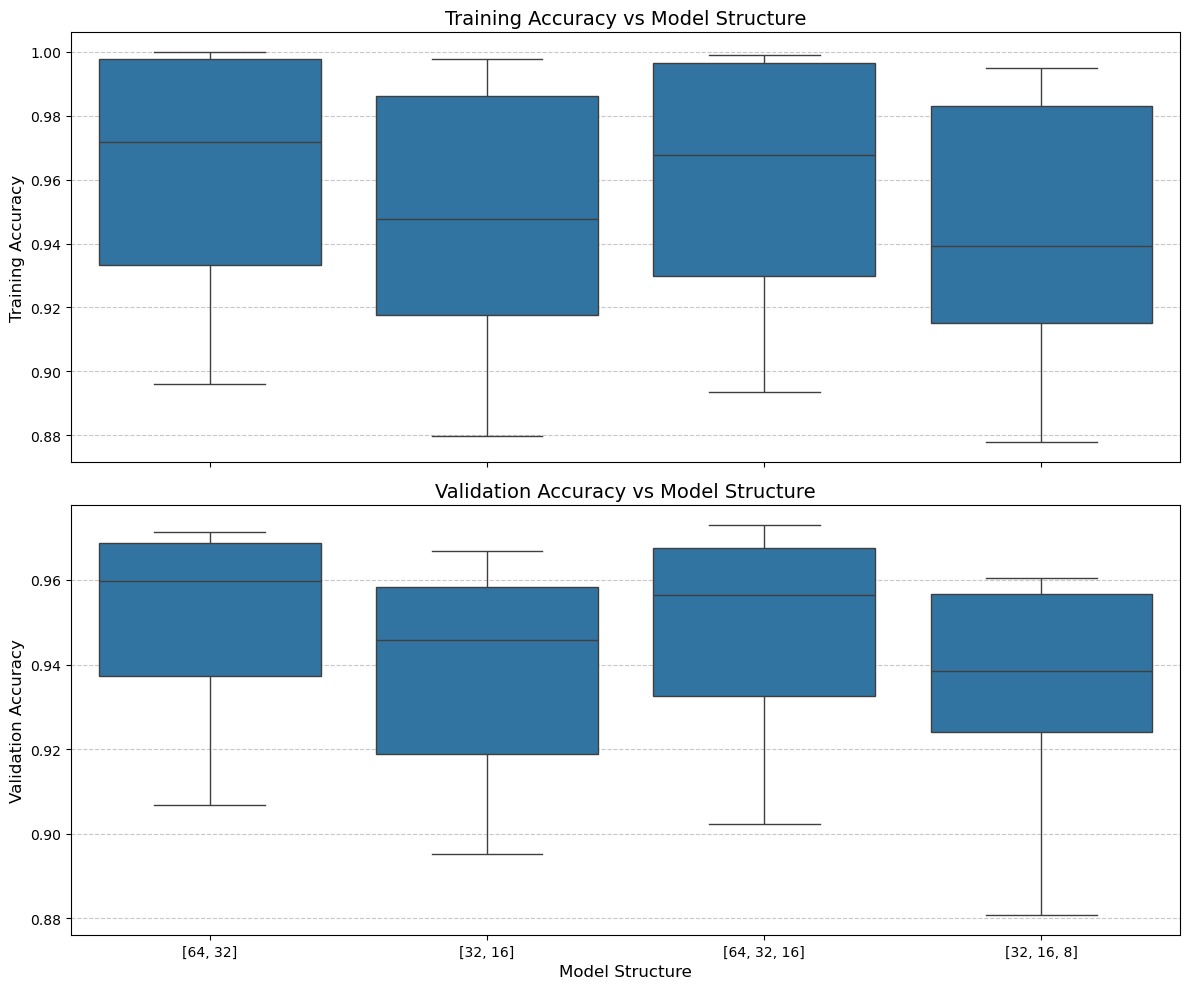

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by the model structure
grouped = results_df.groupby("structure")

# Set up a figure with two subplots (one on top of the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Training Accuracy
sns.boxplot(x="structure", y="train_accuracy", data=results_df, ax=axes[0])
axes[0].set_title("Training Accuracy vs Model Structure", fontsize=14)
axes[0].set_ylabel("Training Accuracy", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bottom plot: Validation Accuracy
sns.boxplot(x="structure", y="val_accuracy", data=results_df, ax=axes[1])
axes[1].set_title("Validation Accuracy vs Model Structure", fontsize=14)
axes[1].set_xlabel("Model Structure", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

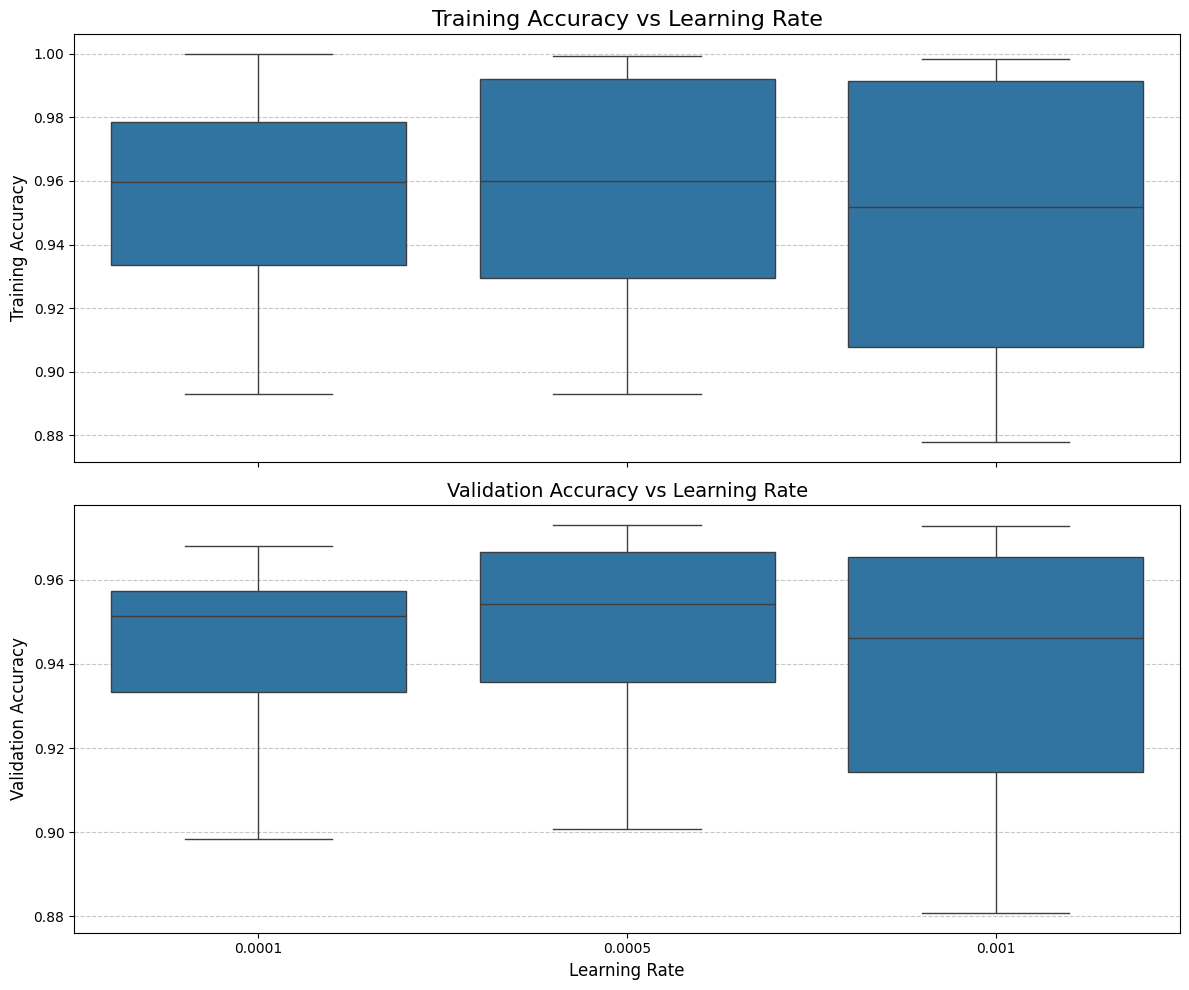

In [58]:
# Group data by learning rates
grouped = results_df.groupby("learning_rate")

# Set up a figure with two subplots (one on top of the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Training Accuracy
sns.boxplot(x="learning_rate", y="train_accuracy", data=results_df, ax=axes[0])
axes[0].set_title("Training Accuracy vs Learning Rate", fontsize=16)
axes[0].set_ylabel("Training Accuracy", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bottom plot: Validation Accuracy
sns.boxplot(x="learning_rate", y="val_accuracy", data=results_df, ax=axes[1])
axes[1].set_title("Validation Accuracy vs Learning Rate", fontsize=14)
axes[1].set_xlabel("Learning Rate", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

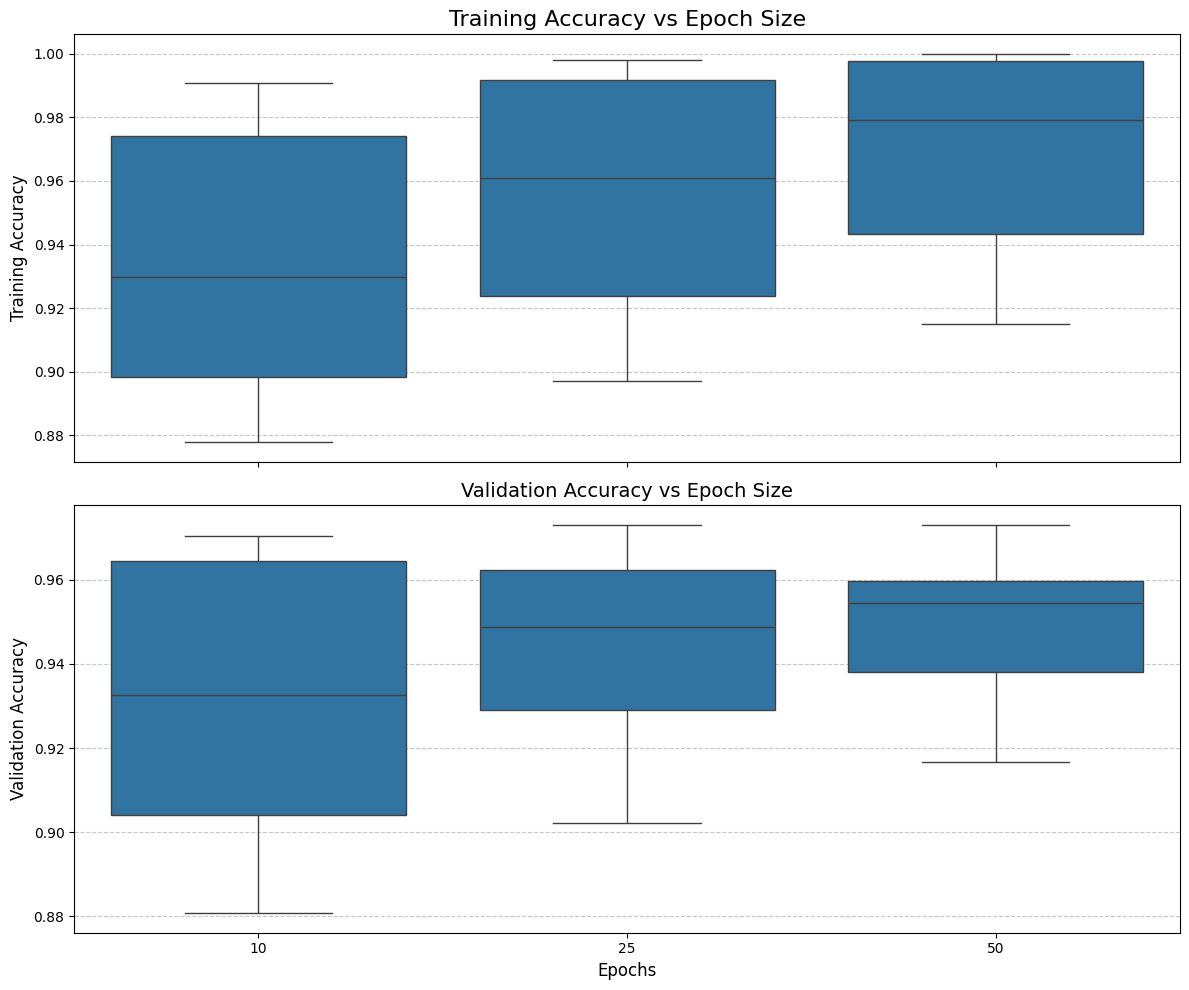

In [ ]:
# Group data by epoch number
grouped = results_df.groupby("epochs")

# Set up a figure with two subplots (one on top of the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Training Accuracy
sns.boxplot(x="epochs", y="train_accuracy", data=results_df, ax=axes[0])
axes[0].set_title("Training Accuracy vs Epoch Size", fontsize=16)
axes[0].set_ylabel("Training Accuracy", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bottom plot: Validation Accuracy
sns.boxplot(x="epochs", y="val_accuracy", data=results_df, ax=axes[1])
axes[1].set_title("Validation Accuracy vs Epoch Size", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

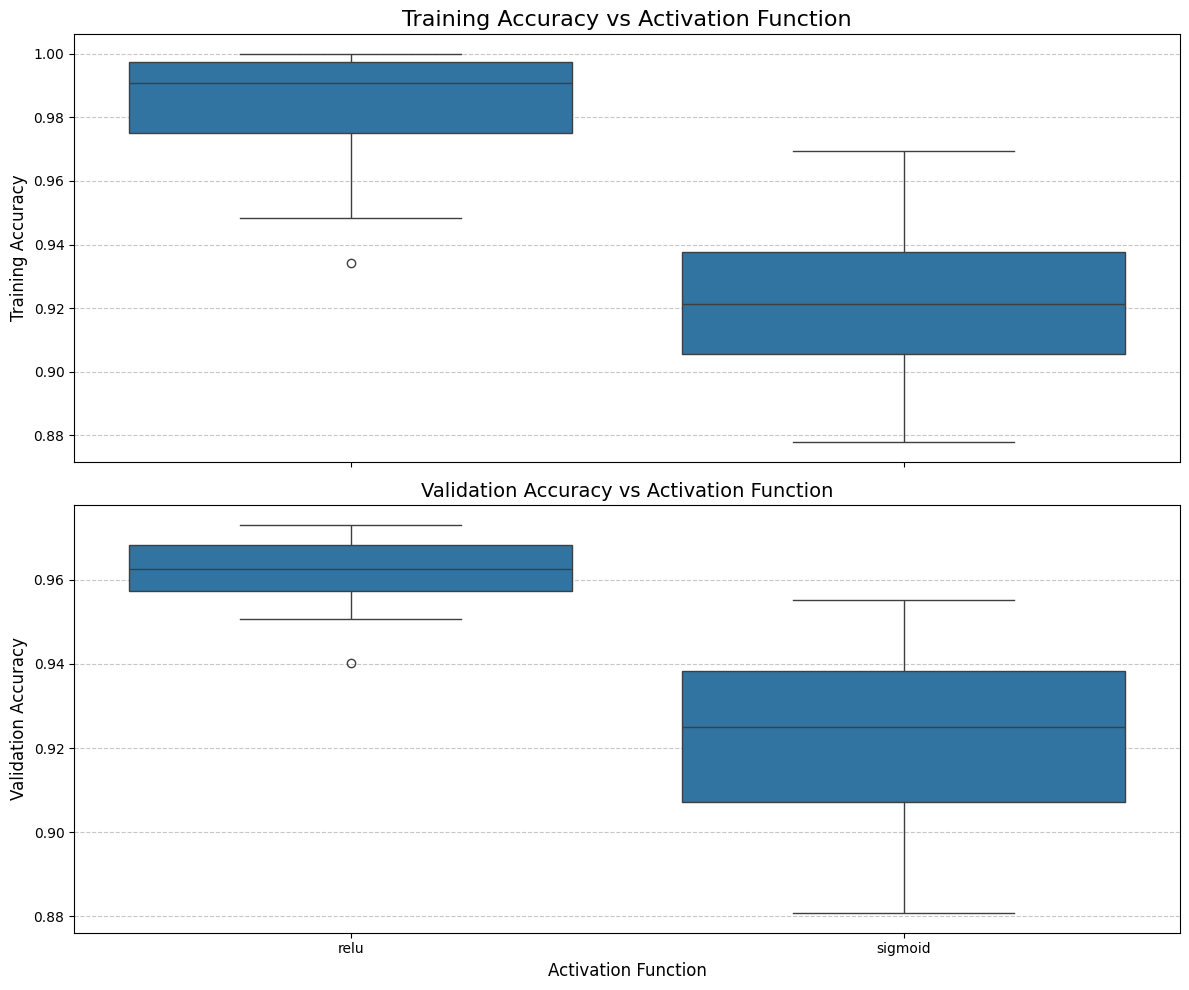

In [59]:
# Group data by activation functions
grouped = results_df.groupby("activation_function")

# Set up a figure with two subplots (one on top of the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Training Accuracy
sns.boxplot(x="activation_function", y="train_accuracy", data=results_df, ax=axes[0])
axes[0].set_title("Training Accuracy vs Activation Function", fontsize=16)
axes[0].set_ylabel("Training Accuracy", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bottom plot: Validation Accuracy
sns.boxplot(x="activation_function", y="val_accuracy", data=results_df, ax=axes[1])
axes[1].set_title("Validation Accuracy vs Activation Function", fontsize=14)
axes[1].set_xlabel("Activation Function", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

# Model Prediction and Evaluation

### Loaded a trained model

In [17]:
from tensorflow.keras.models import load_model
RESULT_DIR = os.path.join(BASE_DIR,'ann_model_results')
MODEL_DIR =  os.path.join(RESULT_DIR,'241129_150900_[64, 32, 16]_0.0005_50_relu')
MODEL_PATH = os.path.join(MODEL_DIR,'model.h5')

loaded_model = load_model(MODEL_PATH)


### Model Evaluation

In [20]:
test_loss, test_acc = loaded_model.evaluate(test_gen,batch_size=BATCH_SIZE)
print(f"Test accuracy: {test_acc}\n"
      f"Test loss: {test_loss}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1743 - accuracy: 0.9726
Test accuracy: 0.972599983215332
Test loss: 0.1743062287569046


### Model Prediction & Testing

In [ ]:
y_loaded_pred = np.argmax(loaded_model.predict(x_test),axis=1)

313/313 [==============================] - 0s 1ms/step


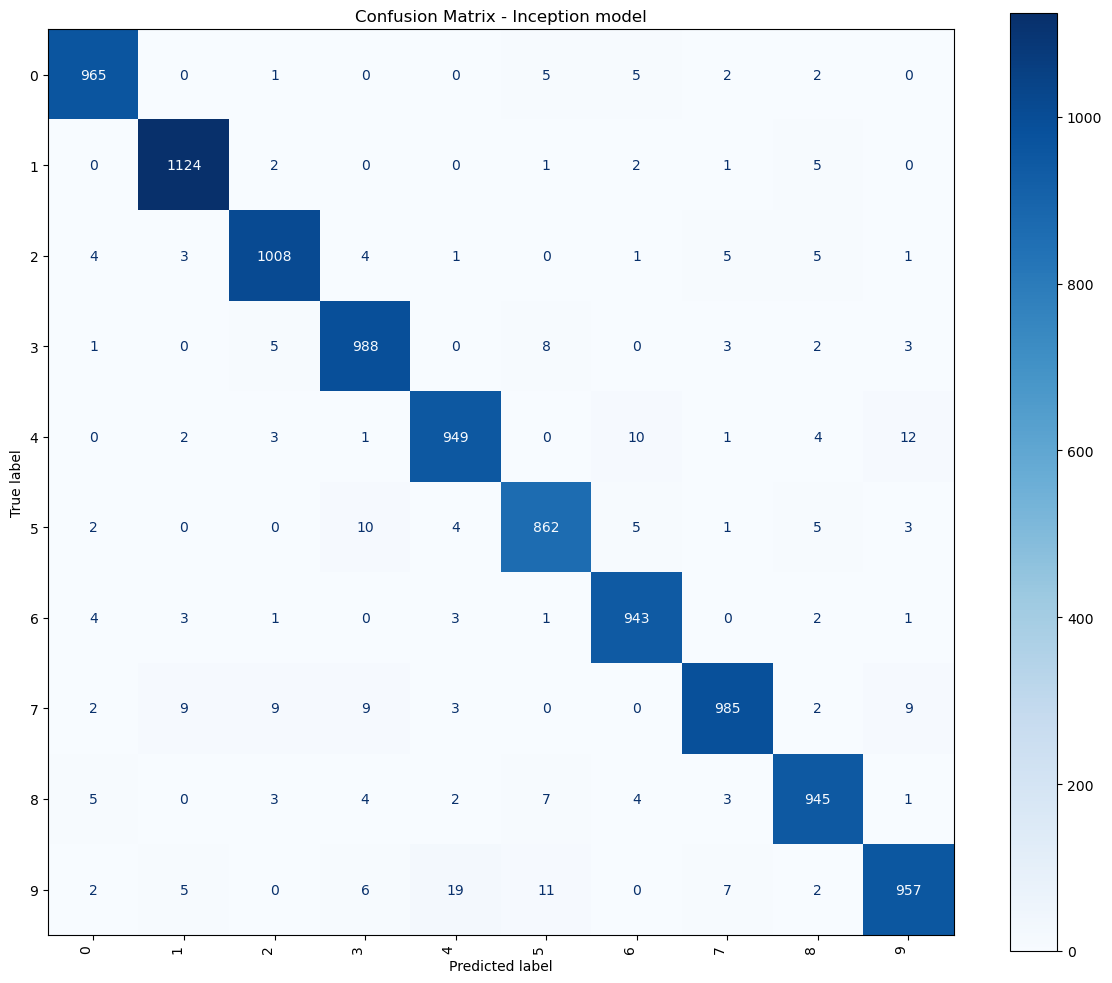

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_loaded_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(10) 
plt.title("Confusion Matrix - Inception model")
plt.xticks(rotation=90, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

## Result Visualization

In [ ]:
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_trainval[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_trainval[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Convolutional Neural Networks

## CNN Model Construction Function